# PetFinder.my - Pawpularity Contest
Date : 2021/09/23 ~ 2022/01/22

Start date : 2021/10/01 

Data : ID를 포함한 13개의 컬럼, 사진 메타데이터, 사진데이터

Metric : RMSE(평균제곱근오차)

Questions Type : 예측(Prediction)

# Exploring

1. 사진을 제외한 데이터들을 이용하여 예측.
2. 사진과 데이터들을 같이 포함하여 예측.
-> 3. 사진만 이용하여 예측

1 :변수끼리의 관계를 중점적으로 확인

2 : 사진안에 어떠한 부분이 Pawpularity 점수에 

유의미한 영향을 끼치는지 확인(LIME)

-> 2DCNN 등등 

핵심 : 사진과 Binary 데이터들을 어떤식으로 조합하여 예측에 사용할지

# CNN

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import xgboost as xgb
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU
from keras.models import Model, load_model,Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
import os
import cv2
from PIL import Image

import datetime
import numpy as np
from tqdm import tqdm
import tensorflow as tf

In [2]:

test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')

In [3]:
labels = train_df[['Id','Pawpularity']]

In [6]:
path = 'C:/Users/현우/Desktop/포트폴리오/Kaggle_PetFinder/train/'
sort = []
for i in tqdm(range(len(labels))):
    img = path + labels.Id.iloc[i] + '.jpg'
    img = Image.open(img)
    sort.append(list(np.array(img).shape))
    

100%|██████████████████████████████████████████████████████████████| 9912/9912 [02:33<00:00, 64.64it/s]


In [7]:
sort_df = pd.DataFrame(sort,columns=['X','Y','Z'])
sort_df.describe()

,X,Y,Z
count,9912.000000,9912.000000,9912.0
mean,904.284302,804.426251,3.0
std,156.905980,270.211921,0.0
min,113.000000,90.000000,3.0
25%,908.750000,675.000000,3.0
50%,960.000000,720.000000,3.0
75%,960.000000,960.000000,3.0
max,1280.000000,1280.000000,3.0


In [4]:
path = 'C:/Users/현우/Desktop/포트폴리오/Kaggle_PetFinder/train/'
imgs = np.empty((len(labels.sample(5000)),512,512,3),dtype=np.uint8)
for i in tqdm(range(len(labels.sample(5000)))):
    img = path + labels.Id.iloc[i] + '.jpg'
    img = Image.open(img).resize((512,512))
    
    imgs[i] = np.uint(img)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:41<00:00, 30.96it/s]


In [5]:
x_train,x_test, y_train, y_test = train_test_split(imgs, labels.iloc[:,-1].sample(5000),test_size=0.2)

print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)

(4000, 512, 512, 3) (1000, 512, 512, 3)
(4000,) (1000,)


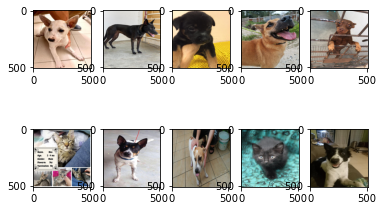

In [6]:
fig = plt.figure()
k = 1
for i in range(len(x_train[:10])):
    img = x_train[i]
    ax = fig.add_subplot(2,5,k)
    ax.imshow(img)
    k+=1

In [7]:
# del train_datagen
# del val_datagen
# del train_generator
# del val_generator
del model

NameError: name 'model' is not defined

In [8]:
with tf.device('/gpu:0'):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        shear_range=0.2,
        zoom_range=0.4,
        horizontal_flip=True
    )
    val_datagen = ImageDataGenerator(
        rescale=1./255
    )
    train_generator = train_datagen.flow(
        x=x_train, y=y_train,
        batch_size=16,
        shuffle=True
    )
    val_generator = val_datagen.flow(
        x=x_test, y=y_test,
        batch_size=16,
        shuffle=False
    )

In [9]:
augs = train_generator.__getitem__(8)

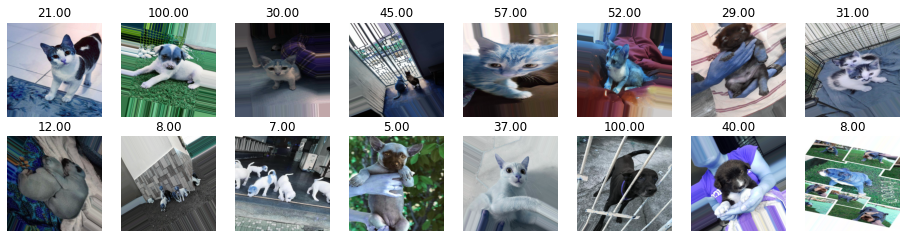

In [10]:
plt.figure(figsize=(16, 8))
for i, img in enumerate(augs[0]):
    plt.subplot(4, 8, i+1)
    plt.title('%.2f' % augs[1][i])
    plt.axis('off')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img.squeeze())

In [11]:
with tf.device('/gpu:0'):
    model = Sequential()
    model.add(Conv2D(32,kernel_size = 3, strides = 1 ,padding='same'))
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(32,kernel_size = 3, strides = 1 ,padding='same'))
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(32,kernel_size = 3, strides = 1 ,padding='same'))
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(32,kernel_size = 3, strides = 1 ,padding='same'))
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(32,kernel_size = 3, strides = 1 ,padding='same'))
    model.add(LeakyReLU())
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())

    model.add(Dense(256,activation='relu'))
    model.add(Dense(128,activation='relu'))
    model.add(Dense(1,activation='linear'))

    model.compile(loss = MeanSquaredError(),optimizer='adam')

    start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
    model.fit_generator(
        train_generator, epochs = 10, validation_data = val_generator,callbacks =  ModelCheckpoint('models/%s.h5' % (start_time), monitor='val_loss', save_best_only=True, mode='min', verbose=1))



C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
250/250 [==============================] - 462s 2s/step - loss: 537.6034 - val_loss: 465.1691

Epoch 00001: val_loss improved from inf to 465.16910, saving model to models\2021_10_08_00_05_38.h5
Epoch 2/10
250/250 [==============================] - 406s 2s/step - loss: 451.7132 - val_loss: 459.4859

Epoch 00002: val_loss improved from 465.16910 to 459.48587, saving model to models\2021_10_08_00_05_38.h5
Epoch 3/10
250/250 [==============================] - 376s 2s/step - loss: 440.8238 - val_loss: 443.2964

Epoch 00003: val_loss improved from 459.48587 to 443.29645, saving model to models\2021_10_08_00_05_38.h5
Epoch 4/10
250/250 [==============================] - 384s 2s/step - loss: 441.2261 - val_loss: 466.6068

Epoch 00004: val_loss did not improve from 443.29645
Epoch 5/10
250/250 [==============================] - 387s 2s/step - loss: 438.7434 - val_loss: 446.0381

Epoch 00005: val_loss did not improve from 443.29645
Epoch 6/10
250/250 [==============================] 

In [12]:
val_data = val_generator.__getitem__(0)


In [25]:
val_data[1]

array([ 74,   1,  60,  47,  21,  36,  29,  28,  48,  14,  21,  42,  34,
        29,  24, 100], dtype=int64)

In [38]:
model.predict(val_data[0])

array([[38.650692],
       [38.647625],
       [38.720966],
       [38.718784],
       [38.67705 ],
       [38.969234],
       [38.708767],
       [38.93445 ],
       [38.872314],
       [38.76472 ],
       [38.6074  ],
       [38.676464],
       [38.467125],
       [38.842537],
       [38.736946],
       [38.58561 ]], dtype=float32)

In [13]:
preds = model.predict(val_data[0])

In [17]:
sub_df = test_df

In [32]:
sub_df

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0
5,b03f7041962238a7c9d6537e22f9b017,0,0,1,1,1,1,1,1,1,0,1,0
6,c978013571258ed6d4637f6e8cc9d6a3,1,0,0,0,1,1,0,1,0,1,1,1
7,e0de453c1bffc20c22b072b34b54e50f,1,0,1,0,0,0,0,0,1,0,0,1


In [33]:
path = 'C:/Users/현우/Desktop/포트폴리오/Kaggle_PetFinder/test/'
imgs = np.empty((len(test_df),512,512,3),dtype=np.uint8)
for i in tqdm(range(len(test_df))):
    img = path + test_df.Id.iloc[i] + '.jpg'
    img = Image.open(img).resize((512,512))
    
    imgs[i] = np.uint(img)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 47.32it/s]


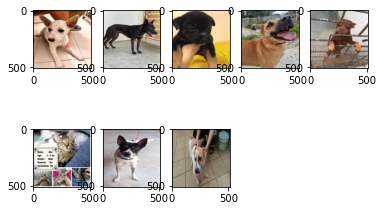

In [35]:
fig = plt.figure()
k = 1
for i in range(len(imgs)):
    img = x_train[i]
    ax = fig.add_subplot(2,5,k)
    ax.imshow(img)
    k+=1

In [45]:
predict = model.predict(imgs)

In [41]:
sub_df = pd.DataFrame()
sub_df['Id'] = test_df['Id']
sub_df['Petpularity'] = predict
sub_df.head()
sub_df.to_csv('./sub_mission/2.csv')

In [42]:
sub_df

,Id,Petpularity
0,4128bae22183829d2b5fea10effdb0c3,32.966709
1,43a2262d7738e3d420d453815151079e,34.556324
2,4e429cead1848a298432a0acad014c9d,32.593838
3,80bc3ccafcc51b66303c2c263aa38486,28.651005
4,8f49844c382931444e68dffbe20228f4,26.425222
5,b03f7041962238a7c9d6537e22f9b017,32.140736
6,c978013571258ed6d4637f6e8cc9d6a3,34.384655
7,e0de453c1bffc20c22b072b34b54e50f,29.462322


In [46]:
predict

array([[32.96671 ],
       [34.556324],
       [32.593838],
       [28.651005],
       [26.425222],
       [32.140736],
       [34.384655],
       [29.462322]], dtype=float32)

In [52]:
mean_squared_error(predict,model.predict(val_data[0])[:8])**0.5

7.8509804277400805